### Notebook to reformat raw 10X matrices into anndata for project `23-0092` prior to `cellbender`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230828

### Import required modules

In [1]:
import anndata
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.0.0
asttokens           NA
backcall            0.2.0
colorama            0.4.6
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
exceptiongroup      1.1.3
executing           1.2.0
h5py                3.9.0
igraph              0.10.8
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numexpr             2.8.7
numpy               1.24.4
packaging           23.1
pandas              2.1.1
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.10.0
prompt_toolkit      3.0.39
psutil         

In [3]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis = 0))

### Read in samples

In [4]:
sample_metadata = pd.read_csv('../data/Sample_Genotype.csv', sep = ',', index_col = 0)
sample_metadata.columns = ['genotype']
sample_metadata.head()

,genotype
Sample,
A9_2,WT
A10_2,WT
A11_2,Mdx
A12_2,Mdx
B1_2,MdxSCID


In [5]:
path = '../data/'
filenames = sample_metadata.index
adatas = [sc.read_10x_mtx(path + filename + '/raw_feature_bc_matrix/') for filename in filenames]
for i in range(len(adatas)):
    adatas[i].obs['sample'] = sample_metadata.index[i]
    for col in sample_metadata.columns:
        adatas[i].obs[col] = sample_metadata[col][i]
adata = adatas[0].concatenate(adatas[1:], batch_categories = sample_metadata.index)
adata.shape

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/tmp/ipykernel_231862/2702798221.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adatas[i].obs[col] = sample_metadata[col][i]
/tmp/ipykernel_231862/2702798221.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adatas[i].obs[col] = sample_metadata[col][i]
/tmp/ipykernel_231862/2702798221.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adatas[i].obs[col] = sample_metadata[col][i]
/tmp/ipykernel_231862/2702798221.py:7: FutureW

(10055673, 32285)

In [6]:
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'].cat.categories

Index(['A10_2', 'A11_2', 'A12_2', 'A9_2', 'B1_2', 'B2_2'], dtype='object')

In [7]:
adata.obs['genotype'] = adata.obs['genotype'].astype('category')
adata.obs['genotype'].cat.categories

Index(['Mdx', 'MdxSCID', 'WT'], dtype='object')

In [8]:
X_is_raw(adata)

True

### Save merged object

In [9]:
adata.write('../data/heart_mm_nuclei-23-0092_ctl231024.raw.h5ad')

### Split object into individual samples for `cellbender`

In [10]:
adata.layers['counts'] = adata.X.copy()

In [11]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()
    
    output_filename = f'{sample_name}_mm_nuclei-23-0092_ctl231024.raw.h5ad'
    sample_adata.write(path + output_filename)

### Generate UMI knee plot per sample

/tmp/ipykernel_231862/2965541337.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


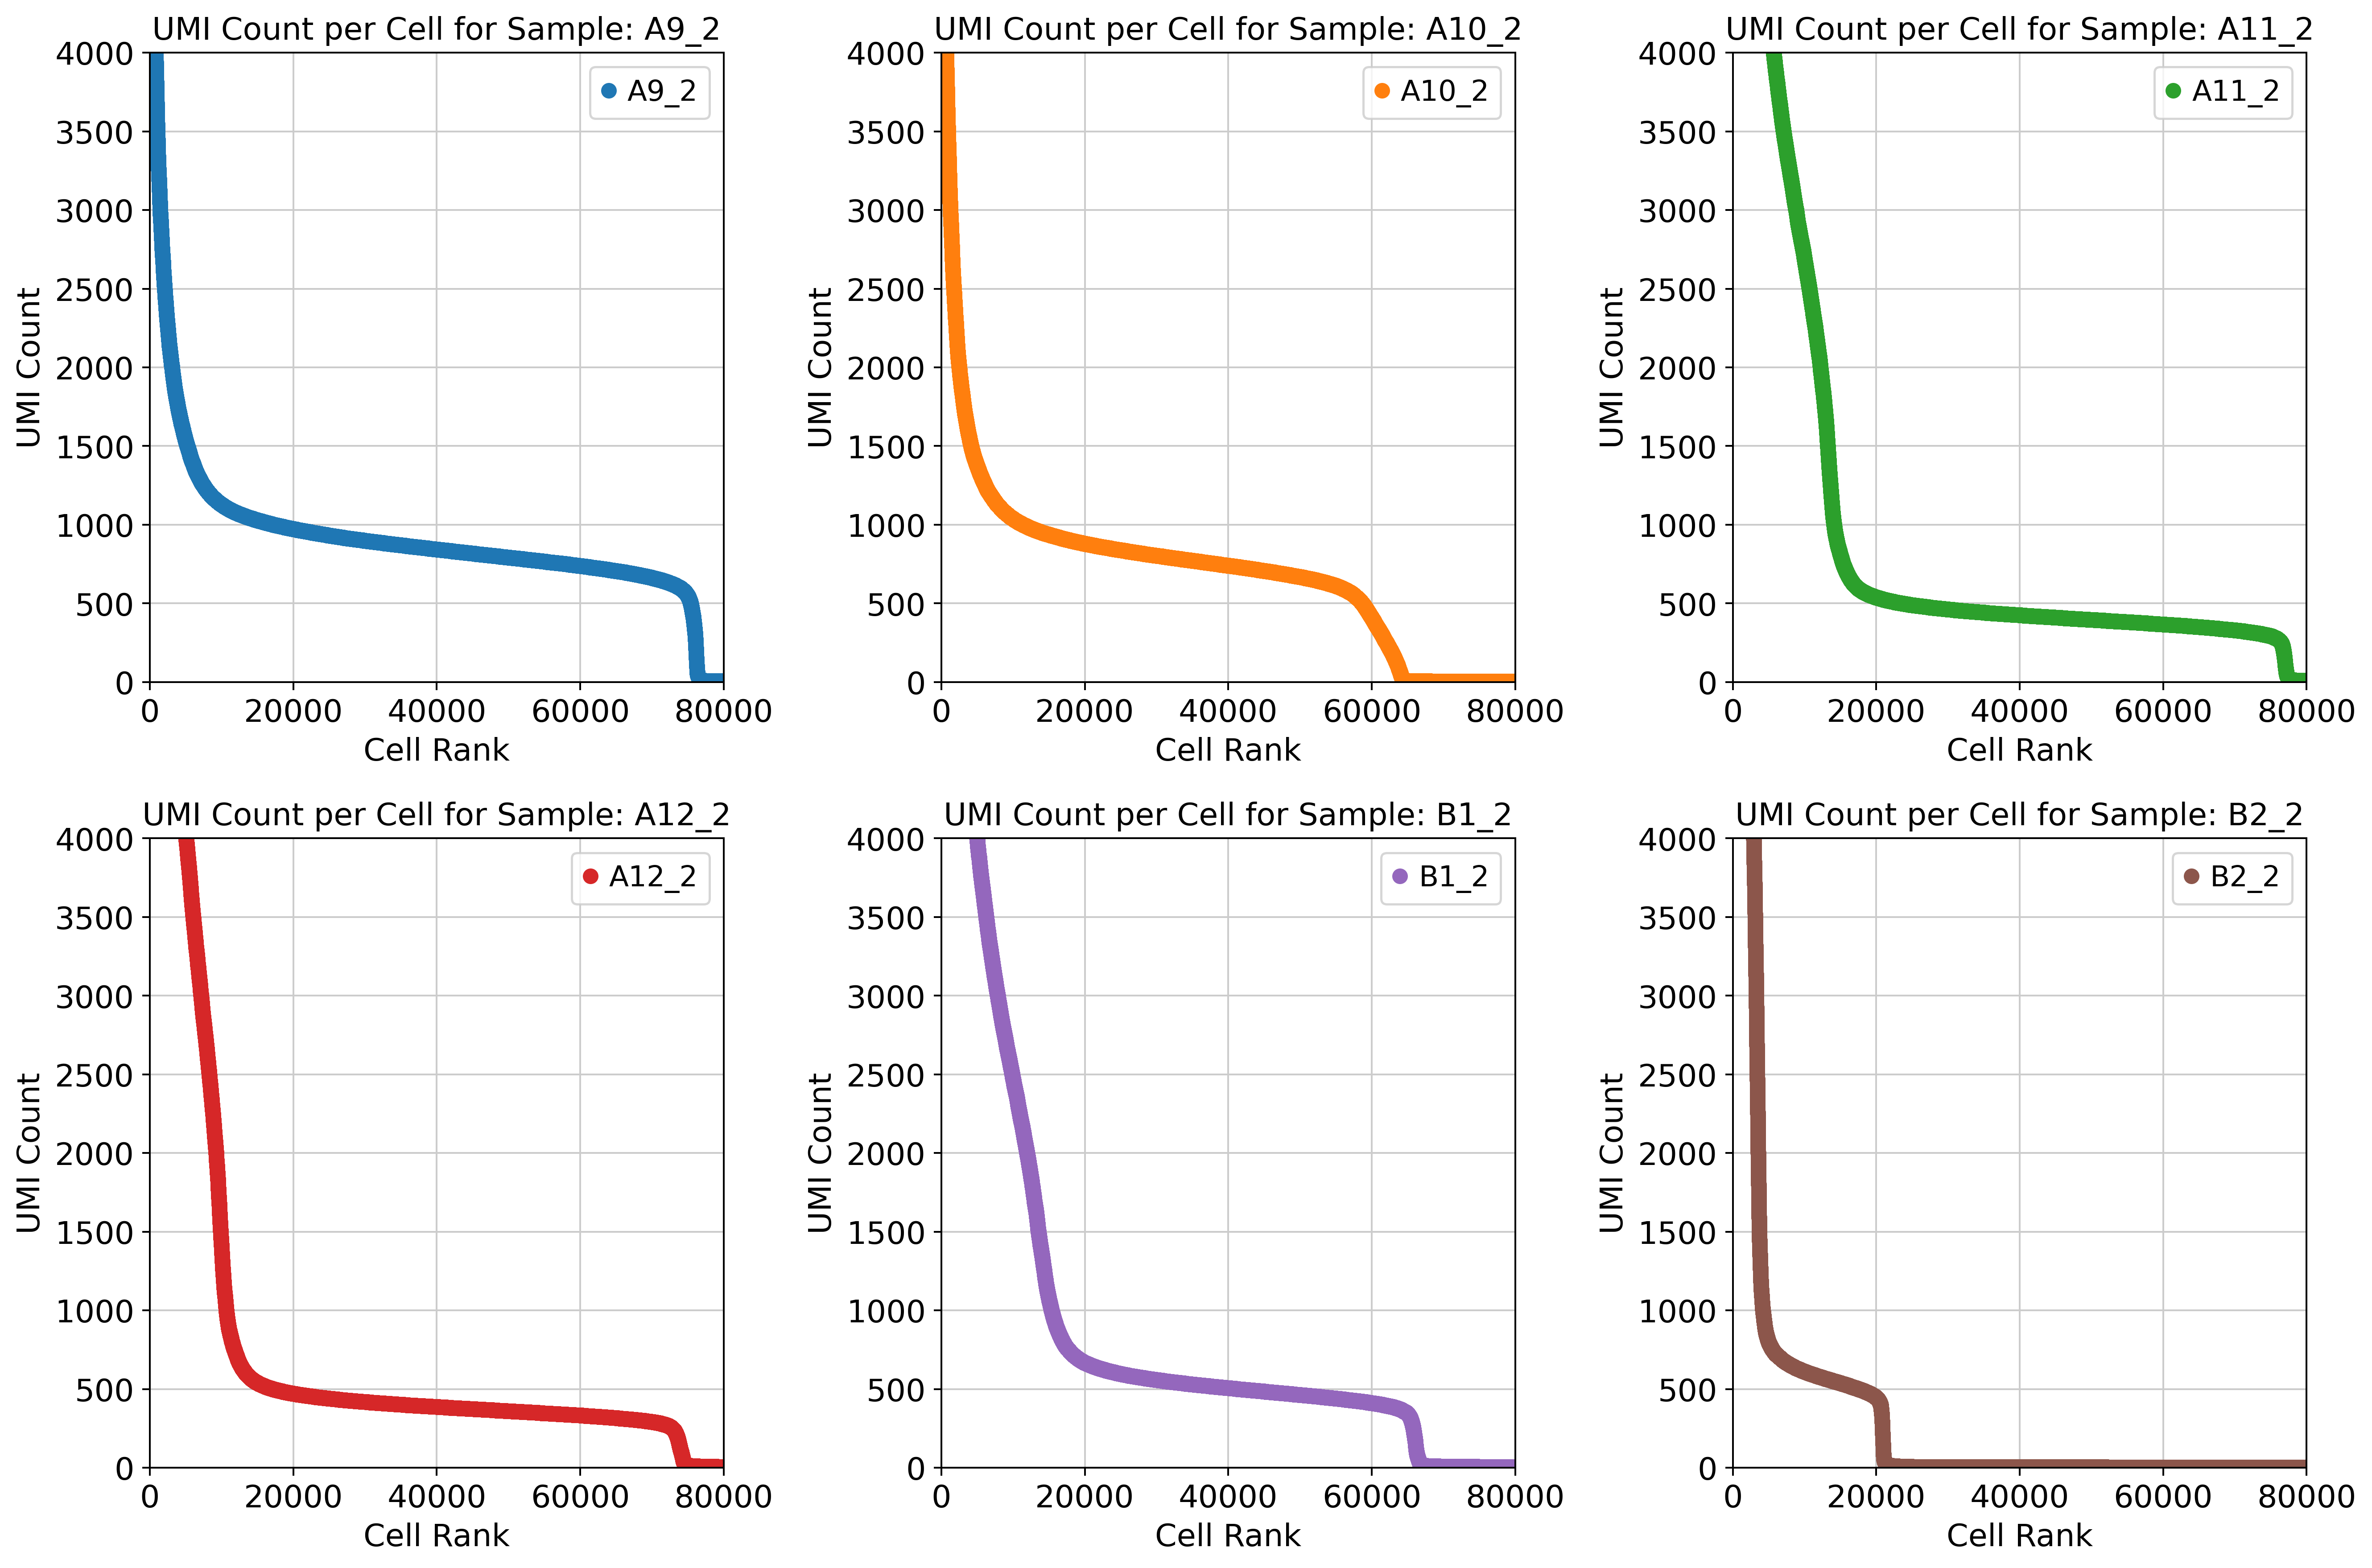

In [12]:
sample_names = adata.obs['sample'].unique()

num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize = (15, 10))
axs = axs.flatten()
color_palette = plt.cm.get_cmap('tab10')

for idx, sample_name in enumerate(sample_names):
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    sample_adata.obs['umi_counts'] = sample_adata.X.sum(axis = 1)
    sample_adata = sample_adata[sample_adata.obs['umi_counts'].argsort()[::-1]]

    ax = axs[idx]
    color = color_palette(idx)
    ax.plot(range(1, len(sample_adata) + 1), sample_adata.obs['umi_counts'], marker = 'o', linestyle = '-', label = sample_name, color = color, linewidth = 0.2)
    ax.set_xlabel('Cell Rank')
    ax.set_ylabel('UMI Count')
    ax.set_title(f'UMI Count per Cell for Sample: {sample_name}')
    ax.set_xlim(0, 80000)
    ax.set_ylim(0, 4000)  # Set x-axis limit
    ax.legend()

plt.tight_layout()
output_filename = 'umi_count_subplot.png'
plt.savefig(output_filename)

plt.show()
